# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [1]:
!pip install tensorflow[and-cuda] numpy==1.25.2 -q

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.17.1


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [3]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                               # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
images = np.load('images_proj.npy')

labels = pd.read_csv('Labels_proj.csv')

In [7]:
print(images.shape)
print(labels.shape)

(631, 200, 200, 3)
(631, 1)


**Observation**:
The dataset contains 631 images, each with a shape of 200x200 pixels and 3 color channels (RGB), indicating that these are colored images. Correspondingly, the labels array has a shape of (631, 1), confirming that there is one label associated with each image. This suggests a one-to-one mapping between images and their binary classification labels.

# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

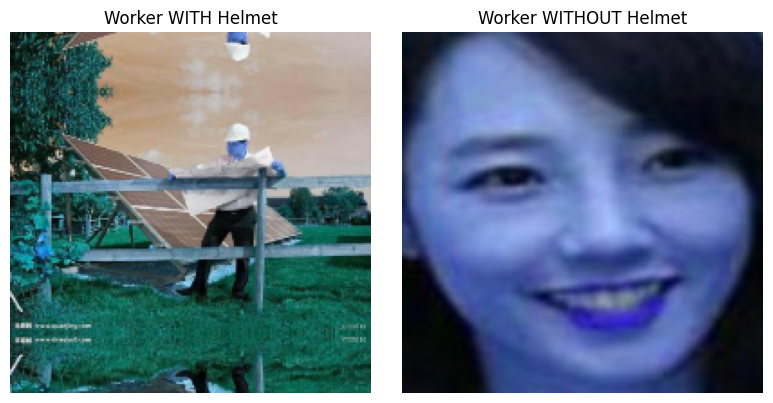

In [8]:
helmet_indices = np.where(labels == 1)[0]
no_helmet_indices = np.where(labels == 0)[0]

# Select one image from each class
helmet_img = images[np.random.choice(helmet_indices)]
no_helmet_img = images[np.random.choice(no_helmet_indices)]

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display "With Helmet" image
axes[0].imshow(helmet_img)
axes[0].set_title("Worker WITH Helmet")
axes[0].axis('off')

# Display "Without Helmet" image
axes[1].imshow(no_helmet_img)
axes[1].set_title("Worker WITHOUT Helmet")
axes[1].axis('off')

# Show the plots
plt.tight_layout()
plt.show()

## Checking for class imbalance


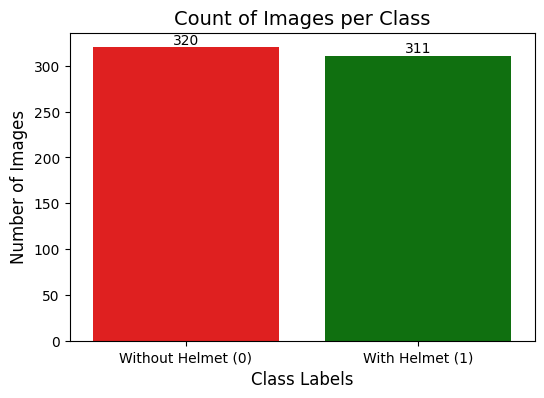

In [9]:
# Create a count plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=labels.iloc[:, 0], palette=['red', 'green'])

# Add exact counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, )

# Add labels
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Count of Images per Class", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["Without Helmet (0)", "With Helmet (1)"])

# Show plot
plt.show()

**Observation:**
The dataset is fairly balanced, with 320 images labeled as 'Without Helmet (0)' and 311 images labeled as 'With Helmet (1)'. This near-equal distribution helps ensure that the model will not be biased toward one class and can learn to distinguish between both classes effectively during training.

# **Data Preprocessing**

## Converting images to grayscale

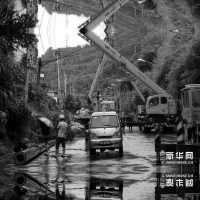

In [10]:
images_gray = []
for i in range(len(images)):
    img_gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    images_gray.append(img_gray)

# Display a sample grayscale image
n = 0
cv2_imshow(images_gray[n])

**Observation:** Due to the limited size of our dataset, we’ll allocate 80% of the data for training, and reserve 10% each for validation and testing. To achieve this, we use the train_test_split() function from scikit-learn, allowing us to divide the dataset into three subsets: training, validation, and test sets.

### Splitting the dataset



In [11]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(np.array(images),labels , test_size=0.2, random_state=42,stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp , test_size=0.5, random_state=42,stratify=y_temp)

In [12]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(504, 200, 200, 3) (504, 1)
(63, 200, 200, 3) (63, 1)
(64, 200, 200, 3) (64, 1)


**Observation:**
The dataset has been successfully split into three subsets:

Training Set: 504 images of shape (200, 200, 3) with 504 corresponding labels

Validation Set: 63 images of shape (200, 200, 3) with 63 labels

Test Set: 64 images of shape (200, 200, 3) with 64 labels

This confirms the 80-10-10 split of the original 631 images and ensures that each subset maintains the correct image-label pairing and dimensional consistency.

### Data Normalization

Since image pixel values range from 0 to 255, we’ll normalize them by scaling—dividing each pixel value by 255—to standardize the data within a 0 to 1 range.

In [13]:
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

**Observation:**
The training, validation, and test image datasets have been normalized by converting the pixel values from integers (0–255) to floating-point values between 0 and 1. This is done by casting each array to float32 and dividing by 255.0, which helps improve model performance and stability during training by ensuring consistent input scaling.

# **Model Building**

##Model Evaluation Criterion

Labels:

With Helmet: Workers wearing safety helmets → labeled as 1

Without Helmet: Workers not wearing safety helmets → labeled as 0

Which scenario is more critical?

1* False Positive (FP): Predicts "With Helmet" when the worker is actually Without Helmet → High Risk
Concern: Missed safety violations could result in serious injuries.

2* False Negative (FN): Predicts "Without Helmet" when the worker is actually With Helmet → Lower Risk
Impact: The worker may receive unnecessary alerts but remains protected.

How to minimize False Positives?
To reduce false positives, our focus is on improving precision, calculated as:

Precision = TP / (TP + FP)

By increasing precision, we ensure that when the system predicts "With Helmet," it's highly likely to be correct—thereby minimizing the chance of overlooking real safety hazards.

## Utility Functions

In [14]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [15]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

The model has 2 main parts:

1. The feature extraction component, consisting of convolutional and pooling layers.
2. The fully connected layers, responsible for performing the final classification and generating predictions.

In [16]:
# Initializing Model
model_1 = Sequential()

# Convolutional layers
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(200,200,3)))
model_1.add(MaxPooling2D((4, 4), padding='same'))
model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2,2), padding='same'))
model_1.add(Conv2D(128, (3,3), activation='relu', padding="same"))

# Flatten and Dense layers
model_1.add(Flatten())
model_1.add(Dense(4, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compile with Adam Optimizer
opt = Adam(learning_rate=0.001)
model_1.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy","Precision"])

# Summary
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       320,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,257 (1.58 MB)

 Trainable params: 413,257 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

**Observation:**
The model is a sequential Convolutional Neural Network (CNN) architecture designed for binary classification. It consists of:

Three convolutional layers with increasing filter sizes (32, 64, and 128), each followed by a MaxPooling2D layer to reduce spatial dimensions.

A Flatten layer that converts the 3D feature maps into a 1D feature vector of size 80,000.

Two Dense (fully connected) layers, where the first has 4 units (possibly acting as an intermediate feature layer), and the second is the final output layer with 1 unit for binary classification.

The model has a total of 413,257 trainable parameters, indicating a moderately complex architecture. There are no non-trainable parameters, confirming all layers are set to be updated during training.

In [17]:
history_1 = model_1.fit(
            X_train_normalized, y_train,
            epochs=10,
            validation_data=(X_val_normalized,y_val),
            shuffle=True,
            batch_size=32,
            verbose=2
)

Epoch 1/10
16/16 - 10s - 634ms/step - Precision: 0.6707 - accuracy: 0.7302 - loss: 0.6449 - val_Precision: 1.0000 - val_accuracy: 0.9841 - val_loss: 0.3638
Epoch 2/10
16/16 - 0s - 14ms/step - Precision: 0.9706 - accuracy: 0.9524 - loss: 0.3101 - val_Precision: 1.0000 - val_accuracy: 0.9365 - val_loss: 0.1813
Epoch 3/10
16/16 - 0s - 14ms/step - Precision: 0.9797 - accuracy: 0.9762 - loss: 0.0852 - val_Precision: 1.0000 - val_accuracy: 0.9841 - val_loss: 0.0797
Epoch 4/10
16/16 - 0s - 14ms/step - Precision: 0.9960 - accuracy: 0.9960 - loss: 0.0134 - val_Precision: 1.0000 - val_accuracy: 0.9683 - val_loss: 0.1337
Epoch 5/10
16/16 - 0s - 15ms/step - Precision: 0.9960 - accuracy: 0.9960 - loss: 0.0141 - val_Precision: 1.0000 - val_accuracy: 0.9841 - val_loss: 0.1272
Epoch 6/10
16/16 - 0s - 14ms/step - Precision: 0.9960 - accuracy: 0.9940 - loss: 0.0118 - val_Precision: 1.0000 - val_accuracy: 0.9841 - val_loss: 0.0419
Epoch 7/10
16/16 - 0s - 14ms/step - Precision: 0.9960 - accuracy: 0.9960 -

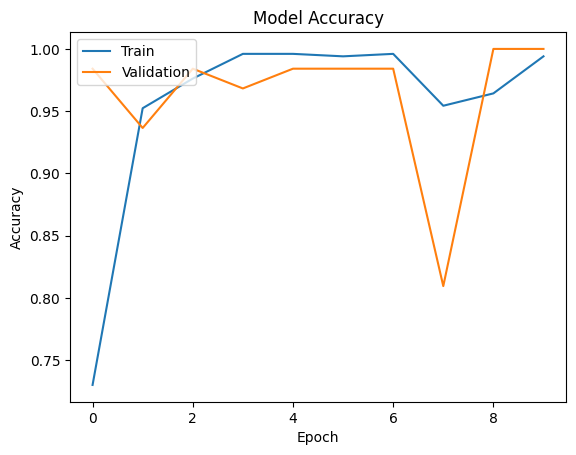

In [18]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observation:**
The training accuracy consistently improves and approaches nearly 100% by the third epoch, indicating that the model is learning well from the training data. Validation accuracy also remains high throughout, with minor fluctuations. A noticeable drop occurs around epoch 7, suggesting potential overfitting or data inconsistency, but it quickly recovers and reaches 100% by the final epoch. Overall, the model demonstrates strong performance with excellent generalization, though the sharp dip in validation accuracy highlights the importance of monitoring for overfitting.

In [19]:
model_1_train_perf = model_performance_classification(model_1, X_train_normalized,y_train)

print("Train performance metrics")
print(model_1_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.998016  0.998016   0.998024  0.998016


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


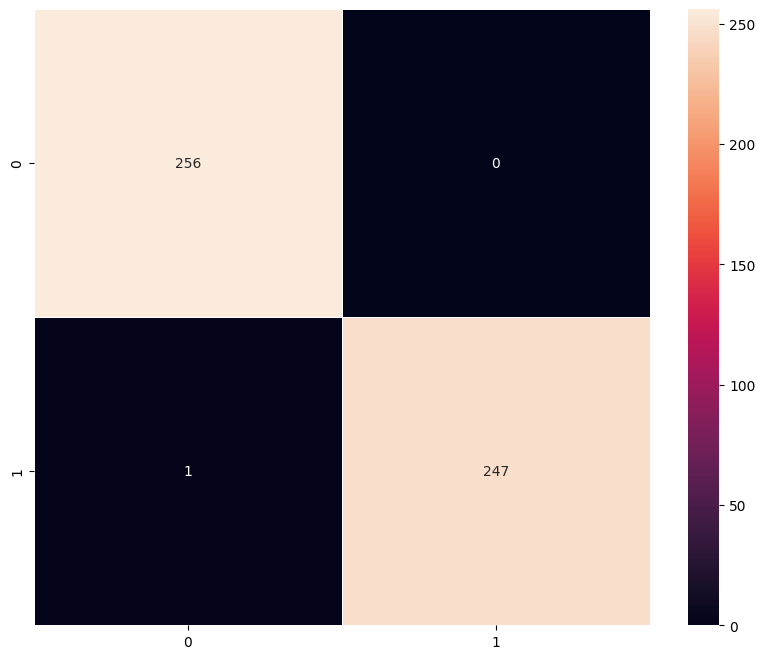

In [20]:
plot_confusion_matrix(model_1,X_train_normalized,y_train)

In [21]:
model_1_valid_perf = model_performance_classification(model_1, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_1_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


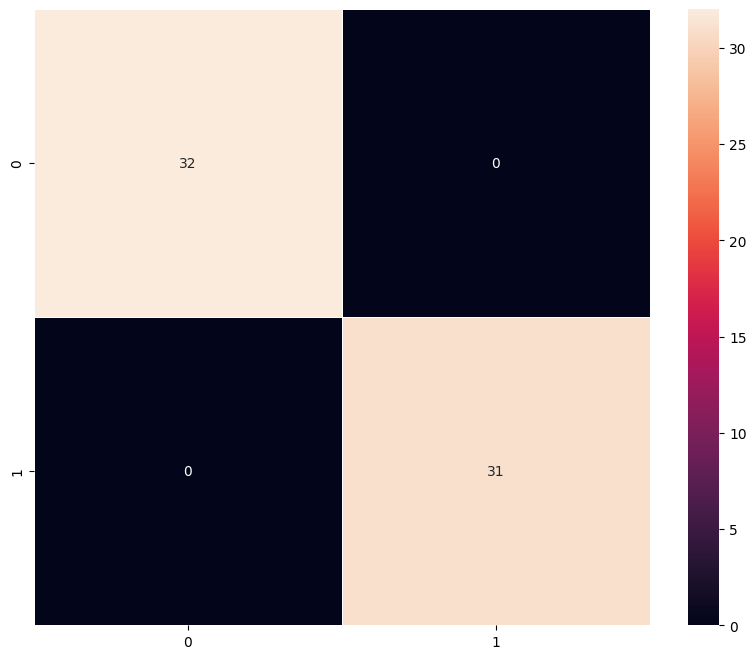

In [22]:
plot_confusion_matrix(model_1,X_val_normalized,y_val)

### Vizualizing the predictions

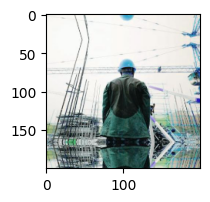

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
Predicted Label: 0
True Label: Label    1
Name: 62, dtype: int64


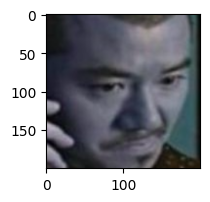

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Label: 0
True Label: Label    0
Name: 512, dtype: int64


In [23]:
# For index 2
plt.figure(figsize=(2,2))
plt.imshow(X_val[12])
plt.show()
prediction = model_1.predict(X_val_normalized[2].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[12]
print('True Label:', true_label)

# For index 33
plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
prediction = model_1.predict(X_val_normalized[2].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[33]
print('True Label:', true_label)

## Model 2: (VGG-16 (Base))

* We’ll be using the pre-trained VGG16 architecture, which was trained on the ImageNet dataset and was the runner-up in the 2014 ImageNet competition.

* For our model, we’ll utilize the convolutional and pooling layers of VGG16 as fixed feature extractors by freezing their weights (i.e., they won’t be updated during training). For the classification task, we’ll append a Flatten layer followed by a single Dense layer.

In [24]:
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(200,200,3))
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**Observation:**
The VGG16 model architecture comprises a deep convolutional neural network with 13 convolutional layers and 5 max-pooling layers, structured into five distinct blocks. It processes input images of size 200×200×3 and gradually reduces spatial dimensions while increasing feature depth through each block.

The model includes a total of 14,714,688 trainable parameters, with no frozen layers in this configuration.

Its depth and parameter count make it highly capable of capturing complex features, which is ideal for tasks like image classification.

However, due to the large number of parameters (~56 MB), it is computationally intensive and may benefit from freezing convolutional layers during transfer learning if overfitting or limited data is a concern.

In [25]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [26]:
model_2 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_2.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_2.add(Flatten())

# Adding a dense output layer
model_2.add(Dense(1, activation='sigmoid'))

In [27]:
opt=Adam(learning_rate=0.001)
# Compile model
model_2.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [28]:
# Generating the summary of the model
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Observation:**
This model, sequential_1, uses the pre-trained VGG16 architecture as a feature extractor by freezing all of its layers (14,714,688 non-trainable parameters). The output from VGG16’s last pooling layer is flattened into a 1D vector of size 18,432 and passed through a single Dense layer with 1 output unit for binary classification.

Only 18,433 parameters are trainable, which belong entirely to the Dense layer.

This approach significantly reduces training complexity and overfitting risk while leveraging VGG16’s rich feature representations.

It is especially effective for small datasets, as it benefits from transfer learning without retraining the entire deep network.

In [29]:
train_datagen = ImageDataGenerator()

In [30]:
# Epochs
epochs = 10
# Batch size
batch_size = 32

history_2 = model_2.fit(train_datagen.flow(X_train_normalized,y_train,
                                      batch_size=batch_size,
                                      seed=42,
                                      shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 363ms/step - accuracy: 0.6953 - loss: 0.5185 - val_accuracy: 1.0000 - val_loss: 0.0276
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0401 - val_accuracy: 1.0000 - val_loss: 0.0262
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_

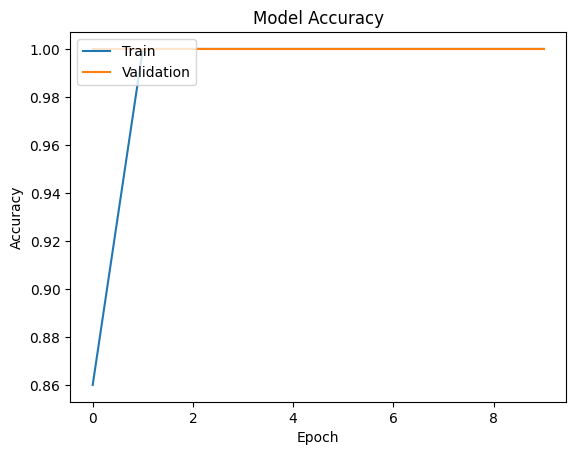

In [31]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observation:**
The model demonstrates excellent accuracy, achieving near-perfect performance on both the training and validation sets by the second epoch, and maintaining that performance throughout the remaining epochs. This rapid convergence and stable accuracy suggest that the model is effectively leveraging the pre-trained VGG16 feature extractor. Since only a small Dense layer was trained, the risk of overfitting is minimal—making this a highly efficient and generalizable solution for the given dataset.

In [32]:
model_2_train_perf = model_performance_classification(model_2,X_train_normalized,y_train)

print("Train performance metrics")
print(model_2_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


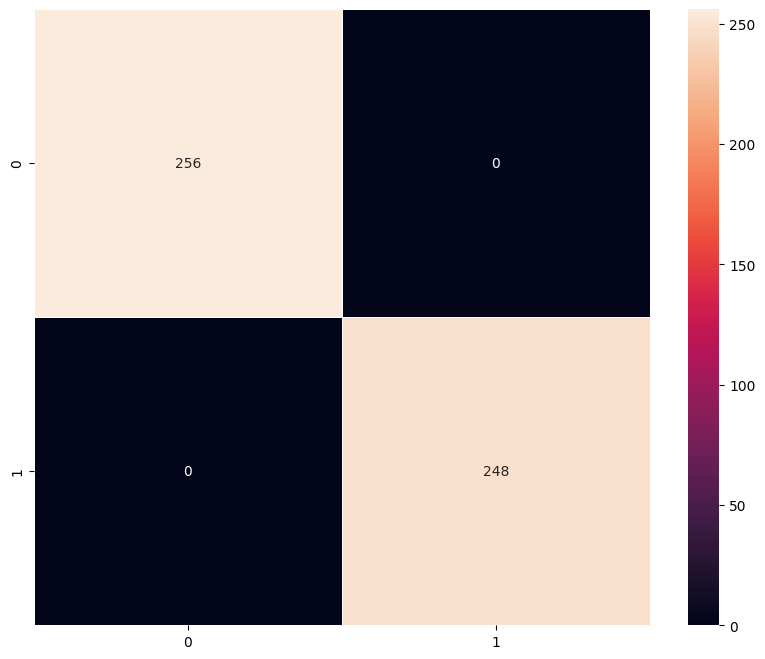

In [33]:
plot_confusion_matrix(model_2,X_train_normalized,y_train)

In [34]:
model_2_valid_perf = model_performance_classification(model_2, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_2_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


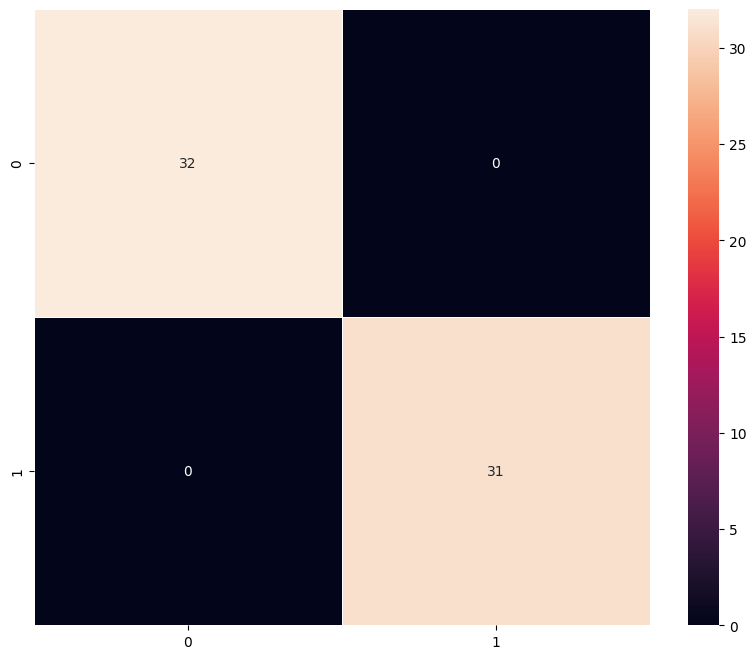

In [35]:
plot_confusion_matrix(model_2,X_val_normalized,y_val)

### Visualizing the prediction:

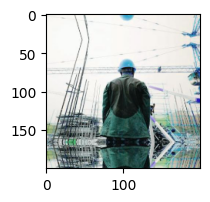

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
Predicted Label: 1
True Label: Label    1
Name: 62, dtype: int64


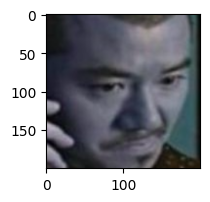

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Label: 0
True Label: Label    0
Name: 512, dtype: int64


In [36]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[12])
plt.show()
prediction = model_2.predict(X_val_normalized[12].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[12]
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
prediction = model_2.predict(X_val_normalized[33].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[33]
print('True Label:', true_label)

## Model 3: (VGG-16 (Base + FFNN))

* We will employ the convolutional and pooling layers as static feature extractors by freezing their weights, ensuring they remain unchanged during training. To handle classification, we’ll append a Flatten layer followed by a feedforward neural network.

In [37]:
model_3 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_3.add(Flatten())

#Adding the Feed Forward neural network
model_3.add(Dense(256,activation='relu'))
model_3.add(Dropout(rate=0.5))
model_3.add(Dense(128,activation='relu'))

# Adding a dense output layer
model_3.add(Dense(1, activation='sigmoid'))

In [38]:
opt = Adam(learning_rate=0.001)

In [39]:
# Compile model
model_3.compile(optimizer=opt,loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [40]:
# Generating the summary of the model
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,466,561 (74.26 MB)

 Trainable params: 4,751,873 (18.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Observation:**
The model sequential_2 builds on the frozen VGG16 architecture as a feature extractor, with its 14,714,688 parameters non-trainable. On top of this, the model includes a more complex classifier:

A Flatten layer to convert VGG16's output into a 1D vector of size 18,432

A Dense layer with 256 units, followed by a Dropout layer to help prevent overfitting

A second Dense layer with 128 units

A final Dense output layer with 1 unit for binary classification

This configuration introduces 4,751,873 trainable parameters, allowing the model to learn more complex decision boundaries than a single dense layer. The added depth and dropout provide improved flexibility and generalization capability while still leveraging the powerful feature extraction of VGG16.

In [41]:
history_3 = model_3.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=32,
                                       seed=42,
                                       shuffle=False),
                    epochs=10,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - accuracy: 0.7751 - loss: 0.4507 - val_accuracy: 1.0000 - val_loss: 2.8946e-05
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6818e-05 - val_accuracy: 1.0000 - val_loss: 1.0121e-05
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9961 - loss: 0.0211 - val_accuracy: 1.0000 - val_loss: 6.1737e-05
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2655e-04 - val_accuracy: 1.0000 - val_loss: 4.9281e-05
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9991 - loss: 8.6773e-04 - val_accuracy: 1.0000 - val_loss: 8.3170e-07
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7348e-05 - val_accuracy: 1.0000 - val_loss: 5.7220e-07
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 5.2034e-04 - val_accuracy: 1.0000 - val_loss: 1.8463e-07
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0

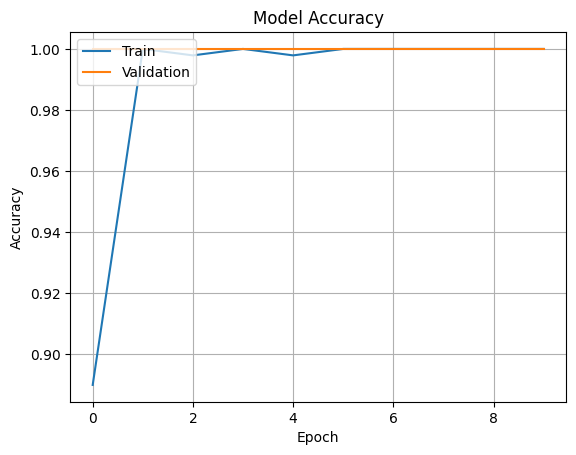

In [42]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observation:**

The model demonstrates excellent training and validation performance. After a rapid rise in accuracy during the initial epochs, both training and validation accuracy converge near 100%, indicating strong model fit and minimal overfitting. The consistently high validation accuracy across epochs also suggests that the model generalizes well on unseen data.

In [43]:
model_3_train_perf = model_performance_classification(model_3, X_train_normalized,y_train)

print("Train performance metrics")
print(model_3_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


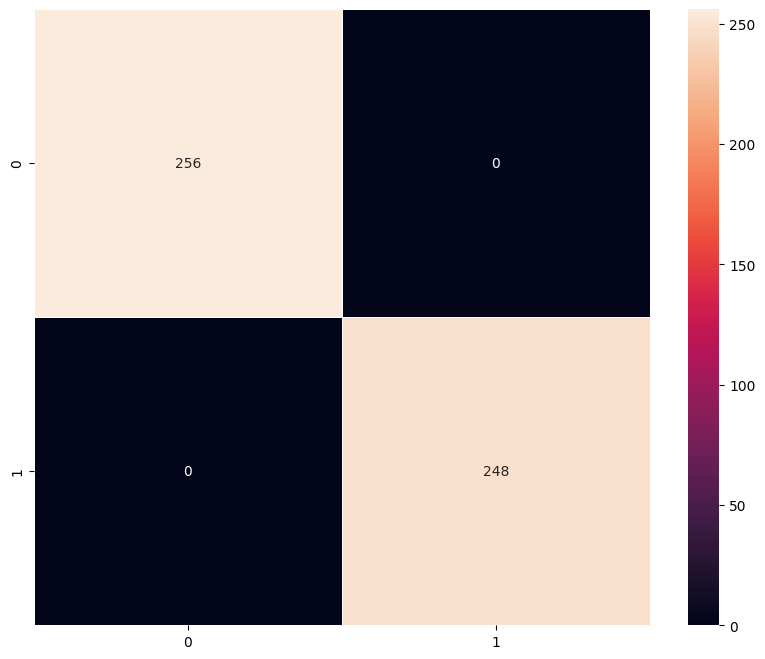

In [44]:
plot_confusion_matrix(model_3,X_train_normalized,y_train)

In [45]:
model_3_valid_perf = model_performance_classification(model_3, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_3_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


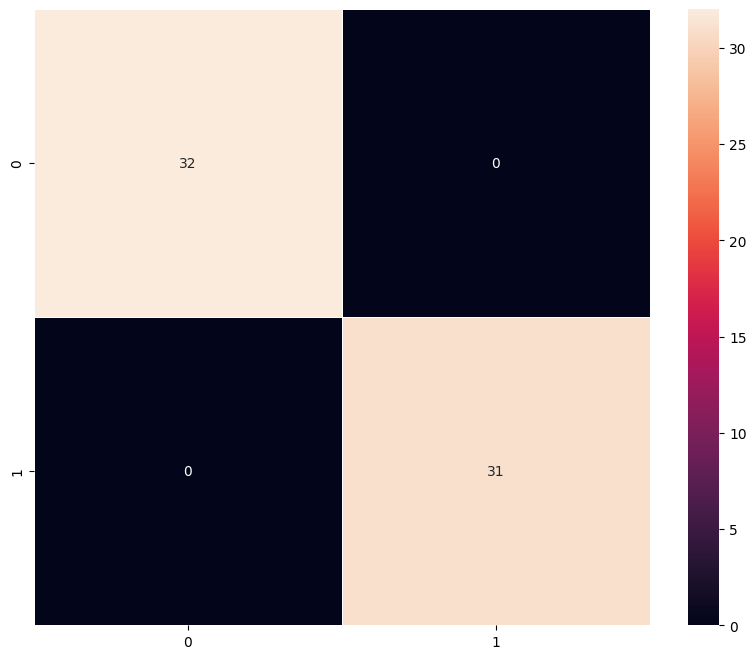

In [46]:
plot_confusion_matrix(model_3,X_val_normalized,y_val)

#### Visualizing the predictions

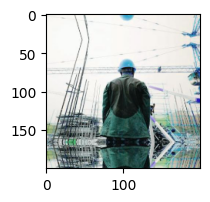

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Label: 1
True Label: Label    1
Name: 62, dtype: int64


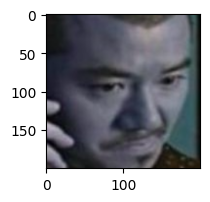

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Label: 0
True Label: Label    0
Name: 512, dtype: int64


In [47]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[12])
plt.show()
prediction = model_2.predict(X_val_normalized[12].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[12]
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
prediction = model_2.predict(X_val_normalized[33].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[33]
print('True Label:', true_label)

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

In [48]:
model_4 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_4.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_4.add(Flatten())

#Adding the Feed Forward neural network
model_4.add(Dense(256,activation='relu'))
model_4.add(Dropout(rate=0.5))
model_4.add(Dense(128,activation='relu'))

# Adding a dense output layer
model_4.add(Dense(1, activation='sigmoid'))

In [49]:
opt=Adam(learning_rate=0.001)
# Compile model
model_4.compile(optimizer=opt,   loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [50]:
# Generating the summary of the model
model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,466,561 (74.26 MB)

 Trainable params: 4,751,873 (18.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Observation:**

This model uses a pre-trained VGG16 network as its base, with the convolutional layers frozen (non-trainable). On top of the extracted features, a custom classification head is added comprising:

A Flatten layer to convert 3D feature maps into a 1D vector

Two Dense layers with 256 and 128 units respectively

A Dropout layer to reduce overfitting

A final Dense layer with 1 unit for binary classification

The model contains approximately 19.47 million parameters, with 4.75 million trainable, reflecting the added classification layers. This architecture leverages the power of transfer learning while keeping training efficient and effective.

In [51]:
# Applying data augmentation
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest',width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1,zoom_range=0.1
                              )

In [52]:
history_4 = model_4.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=32,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 386ms/step - accuracy: 0.6613 - loss: 0.8711 - val_accuracy: 1.0000 - val_loss: 0.0292
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9688 - loss: 0.0472 - val_accuracy: 1.0000 - val_loss: 0.0290
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.9578 - loss: 0.0998 - val_accuracy: 1.0000 - val_loss: 1.1937e-04
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9688 - loss: 0.0325 - val_accuracy: 1.0000 - val_loss: 1.5917e-04
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.9887 - loss: 0.0320 - val_accuracy: 1.0000 - val_loss: 7.2465e-06
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9190e-04 - val_accuracy: 1.0000 - val_loss: 6.4966e-06
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 3.8072e-06
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6694e-0

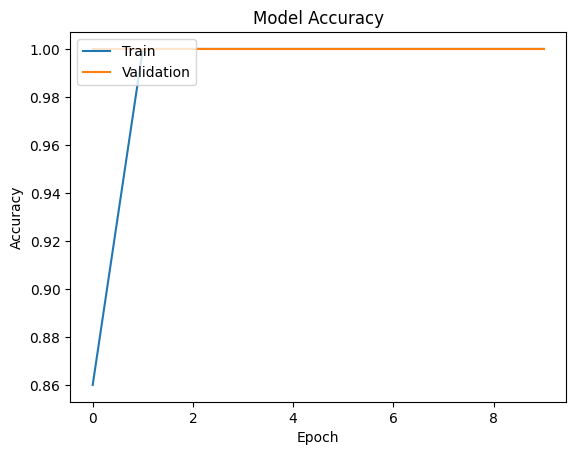

In [53]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observation:**

The model achieved excellent accuracy on both the training and validation datasets, quickly reaching 100% validation accuracy within the first few epochs. This indicates that the model has successfully learned to distinguish between classes with high precision. However, the consistently perfect validation performance may also suggest that the dataset is relatively simple or lacks variability, and further testing on more diverse data would be helpful to confirm generalization.

In [54]:
model_4_train_perf = model_performance_classification(model_4, X_train_normalized,y_train)

print("Train performance metrics")
print(model_4_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


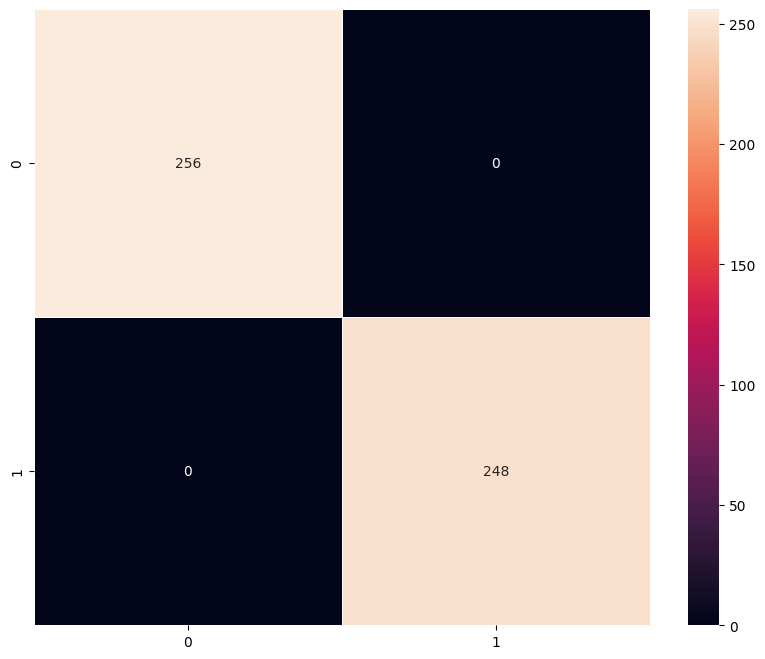

In [55]:
plot_confusion_matrix(model_4,X_train_normalized,y_train)

In [56]:
model_4_valid_perf = model_performance_classification(model_4, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_4_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


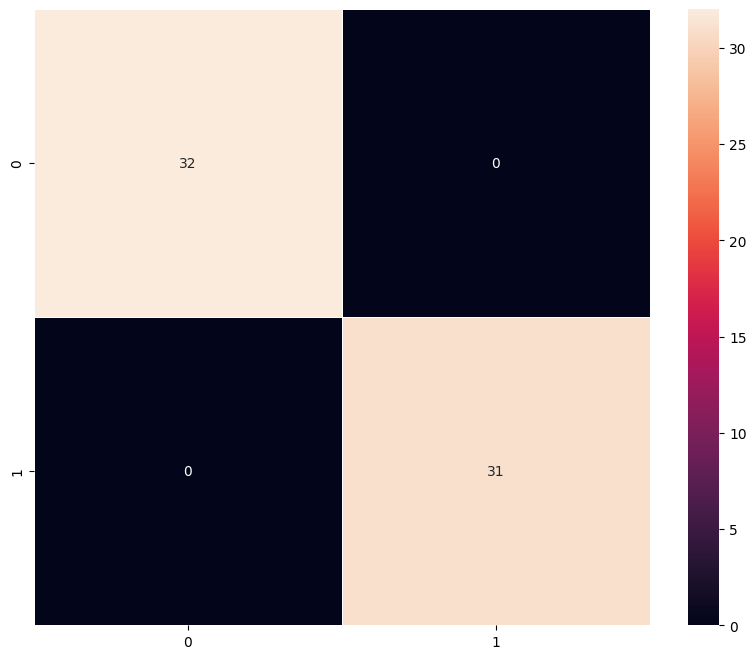

In [57]:
plot_confusion_matrix(model_4,X_val_normalized,y_val)

#### Visualizing the predictions

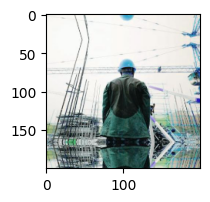

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Label: 1
True Label: Label    1
Name: 62, dtype: int64


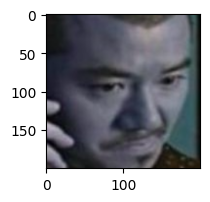

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Label: 0
True Label: Label    1
Name: 108, dtype: int64


In [58]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[12])
plt.show()
prediction = model_2.predict(X_val_normalized[12].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[12]
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
prediction = model_2.predict(X_val_normalized[33].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[1]
print('True Label:', true_label)

# **Model Performance Comparison and Final Model Selection**

In [59]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model_1_train_perf.T,
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [60]:
models_valid_comp_df = pd.concat(
    [
        model_1_valid_perf.T,
        model_2_valid_perf.T,
        model_3_valid_perf.T,
        model_4_valid_perf.T

    ],
    axis=1,
)
models_valid_comp_df.columns = [
 "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [61]:
models_train_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.998016,1.0,1.0,1.0
Recall,0.998016,1.0,1.0,1.0
Precision,0.998024,1.0,1.0,1.0
F1 Score,0.998016,1.0,1.0,1.0


In [62]:
models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0
F1 Score,1.0,1.0,1.0,1.0


In [63]:
models_train_comp_df - models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,-0.001984,0.0,0.0,0.0
Recall,-0.001984,0.0,0.0,0.0
Precision,-0.001976,0.0,0.0,0.0
F1 Score,-0.001984,0.0,0.0,0.0


* All models demonstrated strong performance.

* However, the final model trained with data augmentation is expected to generalize more effectively, as it was exposed to a wider range of image variations during training.

## Test Performance

In [64]:
model_test_perf = model_performance_classification(model_4, X_test_normalized,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [65]:
model_test_perf

,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


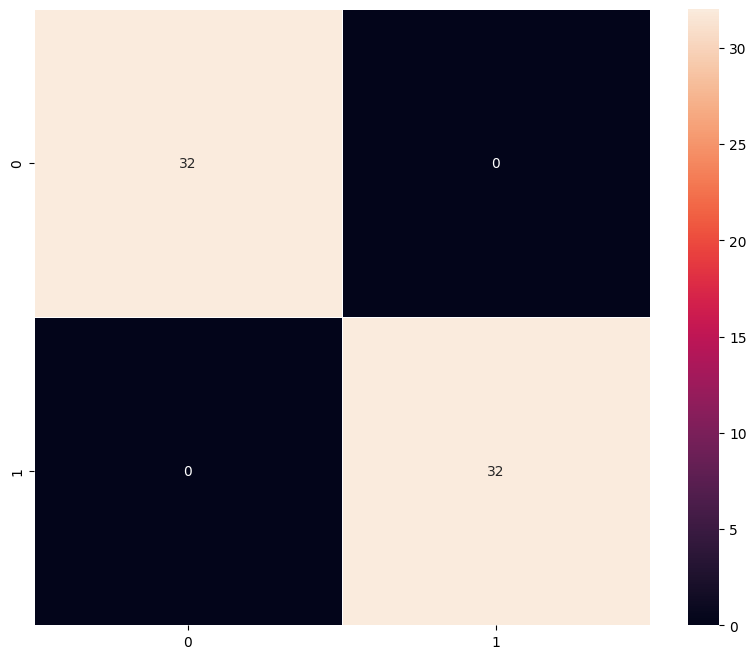

In [66]:
plot_confusion_matrix(model_4, X_test_normalized,y_test)

# **Actionable Insights & Recommendations**

* All models achieved strong performance on both the training and validation sets, with the best-performing model even reaching a perfect score on the test set.

* While some models showed minor fluctuations between training and validation metrics, these differences ultimately converged. This suggests the dataset may be relatively simple, indicating a need for more realistic and diverse data collection.

* Given the consistently high performance across models, the one trained with data augmentation is the preferred choice, as its exposure to varied inputs makes it more likely to generalize well to unseen data.

<font size=5 color='blue'>Power Ahead!</font>
___